In [1]:
%run -i ../scripts/create_variables.py -f ../data/train.csv -c excerpt -nc cleaned_text -nf processed_analysed_train.csv
%run -i ../scripts/create_variables.py -f ../data/test.csv -c excerpt -nc cleaned_text -nf processed_analysed_test.csv

[+] Done!
[+] Done!


In [2]:
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import nltk
from nltk.corpus import stopwords

train_df = pd.read_csv('../data/outputs/processed_analysed_train.csv', encoding = 'latin-1')
test_df = pd.read_csv('../data/outputs/processed_analysed_test.csv', encoding = 'latin-1')
train_df.head()

,id,url_legal,license,excerpt,target,standard_error,cleaned_text,friend,alway,light,...,sentence_count,sentence_score,rd_automatedindex,rd_fogscale,rd_colemanliau,rd_flesch_ease,rd_linearwrite,rd_fleschkincaid_grade,rd_dalechall,rd_consensus
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young peopl return ballroom present decid chan...,0.0,0.0,0.076923,...,11,1.3431,8.3,8.31,8.06,80.31,9.000000,6.1,6.65,9.0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mrs fayr somewhat silent eye rest ...,0.0,0.0,0.000000,...,12,1.5504,7.2,7.53,6.78,82.54,7.285714,5.2,5.92,8.0
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predict snow depart quick came two day s...,0.0,0.0,0.000000,...,8,1.0710,10.1,10.49,7.20,75.74,14.750000,7.9,6.29,8.0
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,outsid palac great garden wall round fill full...,0.0,0.0,0.000000,...,5,0.6693,16.4,13.61,8.54,72.02,12.500000,11.4,6.61,7.0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bear live togeth hous wood one...,0.0,0.0,0.000000,...,5,0.8666,11.8,11.76,4.83,75.47,13.500000,10.0,1.57,12.0


In [3]:
train = train_df.drop(['id', 'url_legal', 'license', 'excerpt', 'cleaned_text'], axis=1)
train.head()

,target,standard_error,friend,alway,light,you,name,end,carri,set,...,sentence_count,sentence_score,rd_automatedindex,rd_fogscale,rd_colemanliau,rd_flesch_ease,rd_linearwrite,rd_fleschkincaid_grade,rd_dalechall,rd_consensus
0,-0.340259,0.464009,0.0,0.0,0.076923,0.0,0.0,0.75,0.0,0.0,...,11,1.3431,8.3,8.31,8.06,80.31,9.000000,6.1,6.65,9.0
1,-0.315372,0.480805,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,...,12,1.5504,7.2,7.53,6.78,82.54,7.285714,5.2,5.92,8.0
2,-0.580118,0.476676,0.0,0.0,0.000000,0.2,0.0,0.00,0.0,0.0,...,8,1.0710,10.1,10.49,7.20,75.74,14.750000,7.9,6.29,8.0
3,-1.054013,0.450007,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,...,5,0.6693,16.4,13.61,8.54,72.02,12.500000,11.4,6.61,7.0
4,0.247197,0.510845,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,...,5,0.8666,11.8,11.76,4.83,75.47,13.500000,10.0,1.57,12.0


## Random Forest

In [4]:
# Remove the targets from the set
# Convert pandas df to np arrays
targets = np.array(train['target'])
feats = train.drop(['target'], axis=1)
features_list = list(feats.columns)
features = np.array(feats)
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=20)
#### NOTE! I'm setting random_state to 20 so we get the same results every time we run the split.
#### Results are reproducible, but maybe this is not the best approach

In [5]:
# Sanity check: we expect the training features number of columns to match the testing feature number of columns 
# and the number of rows to match for the respective training and testing features and the labels
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2267, 515)
Training Labels Shape: (2267,)
Testing Features Shape: (567, 515)
Testing Labels Shape: (567,)


In [6]:
# We establish baseline: We want our model to beat the mean of the standard error.
baseline_errors = train_df['standard_error']
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.49


In [7]:
# Instantiate model with 1000 decision trees
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 20)
#### NOTE! random_state again

# Train the model on training data
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

In [8]:
# Compute performance
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error (MAE): 0.5254057244133103
Mean Squared Error (MSE): 0.5268010676686948
Root Mean Squared Error (RMSE): 0.7258106279662037


In [9]:
### MODEL ANALYSIS

# Get numerical feature relevance
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) 
for pair in feature_importances:
    print('Variable: {:20}{}'.format(*pair))
## All the word-variables related to the TF-IDF analysis don't seem to be relevant for the model.
## We might assume that we don't need information from isolated words.
## We can retest the model using only some of the readability measures.

Variable: rd_dalechall        0.36
Variable: standard_error      0.21
Variable: lexicon_count       0.02
Variable: rd_fogscale         0.02
Variable: rd_linearwrite      0.02
Variable: brain               0.01
Variable: punctuation_count   0.01
Variable: punctuation_score   0.01
Variable: lexicon_score       0.01
Variable: sentence_score      0.01
Variable: rd_automatedindex   0.01
Variable: rd_colemanliau      0.01
Variable: rd_flesch_ease      0.01
Variable: rd_fleschkincaid_grade0.01
Variable: friend              0.0
Variable: alway               0.0
Variable: light               0.0
Variable: you                 0.0
Variable: name                0.0
Variable: end                 0.0
Variable: carri               0.0
Variable: set                 0.0
Variable: though              0.0
Variable: need                0.0
Variable: right               0.0
Variable: night               0.0
Variable: that                0.0
Variable: young               0.0
Variable: quit                0.

In [10]:
features_list = ['rd_dalechall', 'standard_error', 'lexicon_count', 'punctuation_count', 'rd_flesch_ease', 'rd_colemanliau', 'rd_fogscale']
targets = np.array(train['target'])
features = np.array(train[features_list])
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=20)
#### NOTE! I'm setting random_state to 20 so we get the same results every time we run the split.
#### Results are reproducible, but maybe this is not the best approach

In [11]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 20)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
# Compute performance
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error (MAE): 0.5460683148735698
Mean Squared Error (MSE): 0.5263316876956162
Root Mean Squared Error (RMSE): 0.7254872071205779


In [12]:
## We get almost the same results with this version. However, the results are not yet optimal.
## Needs more fine tuning!

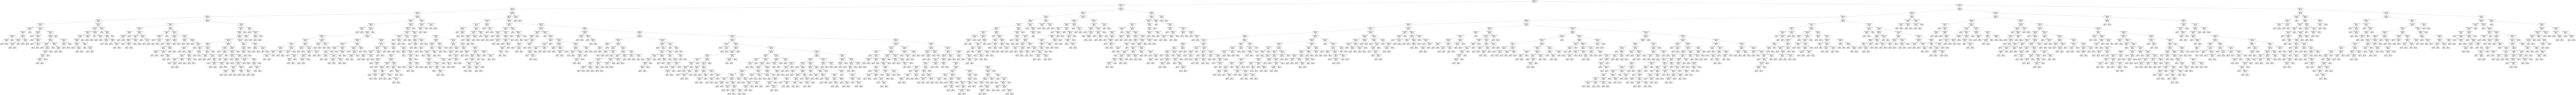

In [13]:
# Visualization of a single tree
from sklearn.tree import export_graphviz
import pydot
from IPython.core.display import Image, display

tree = rf.estimators_[10]
export_graphviz(tree, out_file = 'tree.dot', feature_names = features_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
display(Image('tree.png', height=1700, width=29000, unconfined=True))

## GLM

In [14]:
import statsmodels.api as sm

features_list = ['rd_dalechall', 'standard_error', 'lexicon_count', 'punctuation_count', 'rd_flesch_ease', 'rd_colemanliau', 'rd_fogscale']
endog = np.array(train['target'])
exog = sm.add_constant(np.array(train[features_list]))

glmGauss = sm.GLM(endog, exog, family=sm.families.Gaussian()).fit()
glmGamma = sm.GLM(endog, exog, family=sm.families.Gamma()).fit()

print(glmGauss.summary())
print(glmGamma.summary())

## Both models exhibit a very poor performance. Thus, we might discard them.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2834
Model:                            GLM   Df Residuals:                     2826
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                         0.69140
Method:                          IRLS   Log-Likelihood:                -3494.3
Date:                Tue, 15 Jun 2021   Deviance:                       1953.9
Time:                        23:50:54   Pearson chi2:                 1.95e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7802      0.498      7.591      0.0

/home/edu/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/edu/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/home/edu/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:735: RuntimeWarning: invalid value encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


### Conclusions:

We conclude that GLM is not valid to predict readability complexity, at least with the data that we have. On the other hand, Random Forest looks like a better alternative to GLM. Although not optimal, the results seem quite reasonable. The model would benefit from finding a way to take advantage from TF-IDF.